In [2]:
import os

import numpy as np
import scipy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import lightning as L

# Load Dataset

In [2]:
data = scipy.io.loadmat('../data/barmovie0113extended.data', squeeze_me=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rep_begin_time', 'rep_end_time', 'PickedCells', 'SpikeTimes', 'peak_times', 'stim'])

In [3]:
len(data['SpikeTimes']), len(data['PickedCells'])

(230, 123)

One time unit is equivalent to 0.1 milliseconds = `1e-4` seconds

In [4]:
SECONDS_PER_UNIT = 1e-4

In [5]:
DATASET_LENGTH = (np.max(data['peak_times']) - np.min(data['peak_times'])) * SECONDS_PER_UNIT

In [6]:
def spikes_in_interval(data, t1, t2, neuron_indices=data['PickedCells']):
    for i in neuron_indices:
        all_spikes = data['SpikeTimes'][i] * SECONDS_PER_UNIT
        i1, i2 = np.searchsorted(all_spikes, [t1, t2])
        yield all_spikes[i1:i2]

Let's plot a portion of the dataset

In [7]:
np.diff(data['peak_times'][1:-1])

array([167, 167, 167, ..., 167, 167, 167], shape=(487888,), dtype=int32)

In [8]:
from scipy import signal

sos = signal.butter(4, 5, fs=60, output='sos')
signal.sosfilt(sos, data['stim'])

array([ 3.97994139e-03,  3.04012907e-02,  9.49403128e-02, ...,
       -4.97201732e+01, -4.13150309e+01, -3.33453738e+01], shape=(487889,))

Text(0.5, 0, 'time (s)')

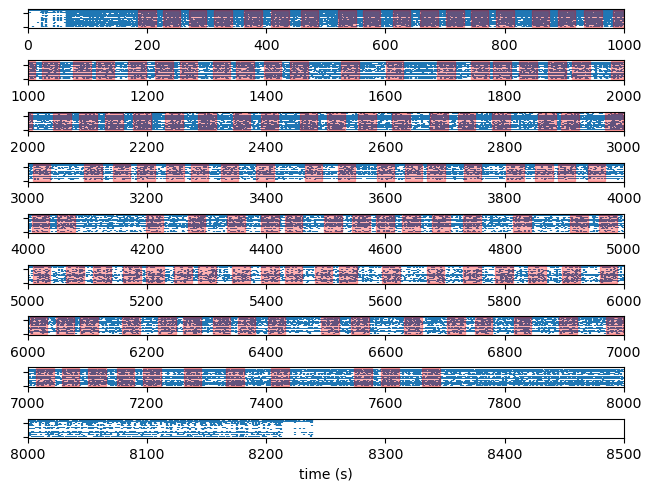

In [9]:
interval_length = 1000.0
MAX_LEN = 8500.0

intervals = np.arange(0, MAX_LEN, interval_length)
fig, axs = plt.subplots(len(intervals), 1, constrained_layout=True)

for ax, interval_start in zip(axs, intervals):

    interval = (interval_start, min(MAX_LEN, interval_start + interval_length))

    ax.set_xlim(*interval)

    spikes = spikes_in_interval(data, *interval)
    ax.eventplot(spikes, linestyles="dotted")

    times = np.arange(interval[0], interval[1], 0.5)

    ax.fill_between(
        times,
        0.0,
        123,
        where=(
            np.digitize(times, data["rep_begin_time"] * SECONDS_PER_UNIT)
            > np.digitize(times, data["rep_end_time"] * SECONDS_PER_UNIT)
        ),
        color='red',
        alpha=0.3,
        zorder=2
    )
    ax.set(yticklabels=[])

    # ax2.vlines(data['rep_begin_time'] * SECONDS_PER_UNIT, -5, -1, color='green')
    # ax2.vlines(data['rep_end_time'] * SECONDS_PER_UNIT, -5, -1, color='red')

axs[-1].set_xlabel("time (s)")

In [10]:
STIMULUS_START = data['peak_times'][0] * SECONDS_PER_UNIT
REPITITIONS_START = data['rep_begin_time'][0] * SECONDS_PER_UNIT
REPITITIONS_END = data['rep_end_time'][-1] * SECONDS_PER_UNIT
STIMULUS_END = data['peak_times'][-1] * SECONDS_PER_UNIT

REPITITIONS_START - STIMULUS_START, STIMULUS_END - REPITITIONS_END

(np.float64(118.76960000000003), np.float64(522.2888000000012))

Write a utility class to load the dataset, so we can use the data for ML tasks.

In [56]:
BIN_WIDTH = 100

In [57]:
from torch.utils.data import Dataset


class NeuronDataSet(Dataset):
    def __init__(self, filename, neurons=[0], intervals=None, delta_t=BIN_WIDTH):
        super().__init__()
        self.data = scipy.io.loadmat(filename, squeeze_me=True)
        self.neurons = neurons
        if intervals is None:
            self.intervals = np.stack(
                (self.data["rep_begin_time"], self.data["rep_end_time"]), axis=-1
            )
        else:
            self.intervals = np.array(intervals).reshape((-1, 2))
        self.delta_t = delta_t
        self.stimulus_std = np.std(self.data["stim"])

    def __len__(self):
        return self.intervals.shape[0]

    def __getitem__(self, index):
        t1, t2 = self.intervals[index]
        return self.time_discretized_spikes(t1, t2)

    def time_discretized_spikes(self, t_start, t_end):
        grid = np.arange(t_start, t_end, self.delta_t)

        peak_times = self.data["peak_times"][:-2]
        idx = np.searchsorted(peak_times, grid)
        stimulus = (
            torch.tensor(
                self.data["stim"][idx],
                dtype=torch.float32,
            )
            / self.stimulus_std
        )

        spikes_binned = []
        # spikes_embedded = []
        for k, n in enumerate(self.neurons):
            spike_times = self.data["SpikeTimes"][n]
            hist, _ = np.histogram(spike_times, bins=np.concat([grid, [t_end]]))
            spikes_binned.append(torch.tensor(hist, dtype=torch.uint8))

        t_seconds = torch.tensor(
            (grid - t_start) * SECONDS_PER_UNIT, dtype=torch.float32
        )
        return (
            t_seconds,
            stimulus,
            torch.stack(spikes_binned, dim=-1),
            # , torch.cat(spikes_embedded, dim=0)
        )


def collate_time_series(batch):
    # first unzip the batch
    t_batch, s_batch, x_batch = zip(*batch)

    # Find the minimum sequence length
    min_len = min(s.shape[0] for s in s_batch)

    t_truncated = torch.stack([t[:min_len] for t in t_batch], dim=1)
    s_truncated = torch.stack(
        [s[:min_len] for s in s_batch], dim=1
    )  # (min_len, batch_size, ...)
    x_truncated = torch.stack(
        [x[:min_len] for x in x_batch], dim=1
    )  # (min_len, batch_size, ...)

    return t_truncated, s_truncated, x_truncated  # , list(x_embedded)

In [58]:
full_dataset = NeuronDataSet(
    "../data/barmovie0113extended.data",
    [0, 1, 2, 3],
    [data["peak_times"][0], data["rep_begin_time"][0]],
)
t, s, x = collate_time_series([b for b in full_dataset])
t.shape, s.shape, x.shape

(torch.Size([11877, 1]), torch.Size([11877, 1]), torch.Size([11877, 1, 4]))

Plot one repition of the stimulus

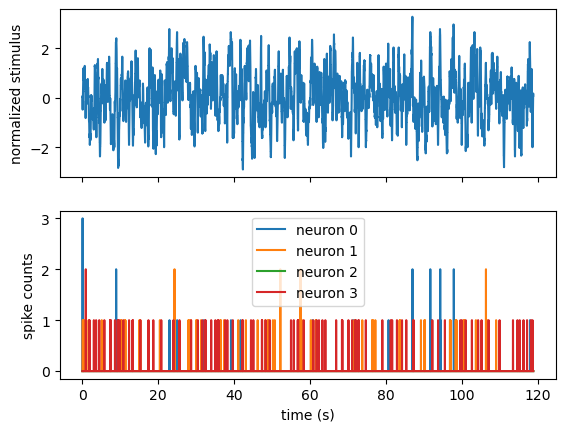

In [59]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(t[:, 0], s[:, 0])
ax1.set_ylabel('normalized stimulus')
for i in range(x.size(2)):
    ax2.plot(t[:, 0].numpy(), x[:, 0, i].numpy(), label=f'neuron {i}')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('spike counts')
ax2.legend()

# Input SDE

## Stochastic Harmonic Oscillator

In [60]:
TAU = 50e-3
OMEGA_0 = 9.42

Because the damping coefficient
$$
\gamma = \frac{1}{2 \omega_0 \tau}
$$
is larger than 1, the system is overdamped. However, the system is close to critical damping.

In [61]:
DAMPING_COEFFICIENT = 1.0 / (2 * OMEGA_0 * TAU)
DAMPING_COEFFICIENT

1.0615711252653928

In [62]:
STATIONARY_SIGMA = torch.tensor([1.0, 1/(4*DAMPING_COEFFICIENT**2)])

This defines a stochastically driven harmonic oscillator with variance $\langle x^2 \rangle = 1$.

In [63]:
import torchsde

class StochasticHarmonicOscillator(nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito'

    def __init__(self, damping_coefficient = DAMPING_COEFFICIENT, tau = TAU):
        super().__init__()

        self.A = torch.tensor([[0.0, 1.0],
                               [-1 / (4 * damping_coefficient**2), - 1.0]], dtype=torch.float32) / tau
        
        self.B = torch.tensor([[0.0, 1.0 / (np.sqrt(2.0) * damping_coefficient)]], dtype=torch.float32) / np.sqrt(tau)

    # Drift
    def f(self, t, y):
        return y @ self.A.T

    # Diffusion
    def g(self, t, y):
        return self.B.expand(y.size(0), 2).unsqueeze(-1)

In [64]:
y0 = torch.randn(1000, 2) * STATIONARY_SIGMA
model = StochasticHarmonicOscillator()
model.A, model.B

(tensor([[  0.0000,  20.0000],
         [ -4.4368, -20.0000]]),
 tensor([[0.0000, 2.9789]]))

In [65]:
time = t[:, 0]
time

tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 1.1874e+02, 1.1875e+02,
        1.1876e+02])

In [66]:
y = torchsde.sdeint(model, y0, time, method='euler', dt=5e-3)

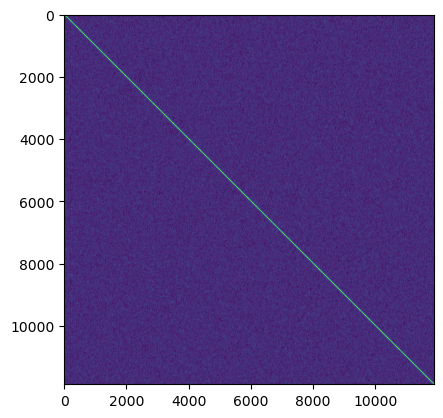

In [67]:
plt.imshow(y[...,0].cov())

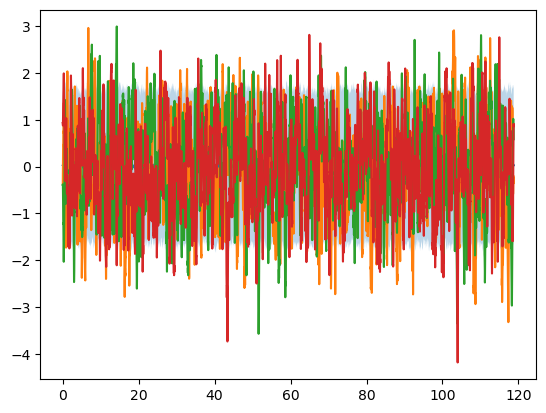

In [68]:
plt.plot(t[:,0], y[:, :, 0].mean(1))
plt.fill_between(t[:,0], y[:, :, 0].quantile(0.05, 1), y[:, :, 0].quantile(0.95, 1), alpha=0.3)
plt.plot(t[:,0], y[:, [0, 1, 2], 0])

In [69]:
test_s = y[:, :, 0]
test_s.shape

torch.Size([11877, 1000])

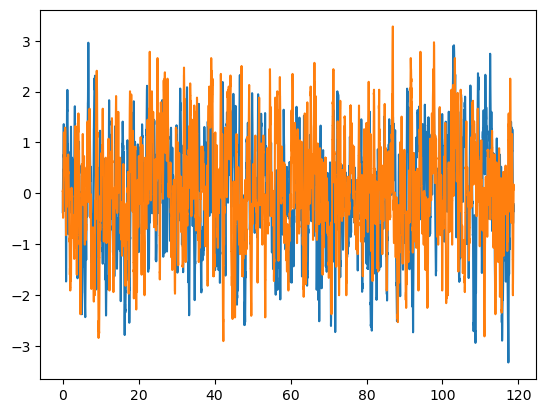

In [70]:
plt.plot(t[:,0], test_s[:, 0])
plt.plot(t[:,0], s[:, 0])

## Gaussian Process

In [71]:
class StochasticHarmonicOscillatorKernel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, t1, t2):
        t = (t2.unsqueeze(1) - t1).abs() / TAU
        i_omega = np.sqrt(0.25 - 1/(4 * DAMPING_COEFFICIENT**2))
        pos = torch.exp((i_omega - 0.5) * t)
        neg = torch.exp((-i_omega - 0.5) * t)
        c = 0.5 * (pos + neg)
        s = 0.5 * (pos - neg)
        return c + 0.5 * s / i_omega

In [72]:
class GProcess(nn.Module):
    def __init__(self, kernel):
        super().__init__()
        self.kernel = kernel
        # K = kernel(t_obs, t_obs.unsqueeze(1))
        # self.L = torch.linalg.cholesky(K + sigma * torch.eye(t_obs.size(0)))
        # self.alpha = torch.cholesky_solve(x_obs.unsqueeze(1), self.L)
        # self.t_obs = t_obs

    def forward(self, t, z, u):
        K_uu = self.kernel(z, z)
        L = torch.linalg.cholesky(K_uu)
        alpha = torch.cholesky_solve(u.unsqueeze(1), L)
        K_yu = self.kernel(t, z)
        mean = (K_yu.T @ alpha).squeeze(1)
        v = torch.linalg.solve_triangular(L, K_yu, upper=False)
        cov = self.kernel(t, t) - v.T @ v
        return torch.distributions.MultivariateNormal(mean, cov)
    
    def prior(self, t):
        mean = torch.zeros_like(t)
        cov = self.kernel(t, t)
        return torch.distributions.MultivariateNormal(mean, cov)

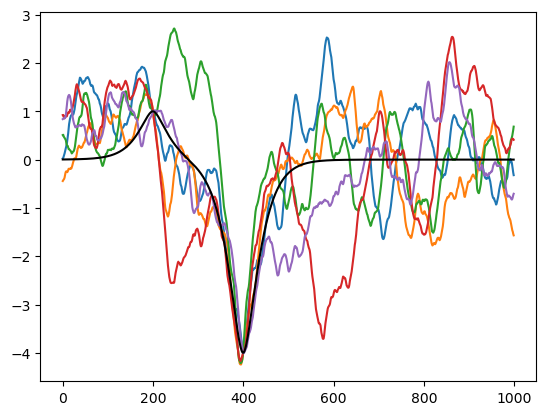

In [73]:
kernel = StochasticHarmonicOscillatorKernel()

z = torch.tensor([1.0, 2.0])
u = torch.tensor([1.0, -4.0])

gaussian_process = GProcess(kernel)

prior = gaussian_process.prior(torch.linspace(0, 5, 1000))
post = gaussian_process(torch.linspace(0, 5, 1000), z, u)
plt.plot(post.sample((5,)).T)
plt.plot(post.mean, color='black')

## Variational GP

In [74]:
from torch.distributions.lkj_cholesky import LKJCholesky
from torch.distributions.multivariate_normal import MultivariateNormal

class VariationalGP(nn.Module):
    def __init__(self, t_obs):
        super().__init__()
        self.t_obs = t_obs
        self.m = nn.Parameter(torch.zeros((t_obs.size(0), 1)))
        self.S_L = nn.Parameter(LKJCholesky(t_obs.size(0), 0.5).sample())
        self.kernel = StochasticHarmonicOscillatorKernel()
        self.K_uu = self.kernel(self.t_obs, self.t_obs)
        self.L_uu = torch.linalg.cholesky(self.K_uu)
    
    def get_sl(self):
        S_L = torch.tril(self.S_L)

        # Ensure positive diagonal for positive-definiteness
        diag_indices = torch.arange(S_L.size(0))
        S_L[diag_indices, diag_indices] = nn.functional.softplus(S_L[diag_indices, diag_indices])
        return S_L

    def forward(self, t, x_emb, batch_size):
        S_L = self.get_sl()

        K_yy = self.kernel(t, t)
        K_yu = self.kernel(t, self.t_obs)
        A = torch.cholesky_solve(K_yu, self.L_uu).T

        f_mean = A @ self.m
        v1 = A @ S_L
        v2 = A @ self.L_uu
        f_cov = K_yy + v1 @ v1.T - v2 @ v2.T
        samples = MultivariateNormal(f_mean.squeeze(1), f_cov).rsample((batch_size,)).T

        prior = MultivariateNormal(torch.zeros_like(self.m).squeeze(1), scale_tril=self.L_uu)
        posterior = MultivariateNormal(self.m.squeeze(1), scale_tril=S_L)
        kl_div = torch.distributions.kl_divergence(posterior, prior)

        return samples, kl_div
    
    def importance_weights(self, t, samples, t_c, c):
        S_L = self.get_sl()

        K_cc = self.kernel(t_c, t_c)
        K_yc = self.kernel(t, t_c)
        L_cc = torch.linalg.cholesky(K_cc)
        prior_mean = (K_yc.T @ torch.cholesky_solve(c.T.unsqueeze(2), L_cc)).squeeze(-1)

        K_yy = self.kernel(t, t)
        B = torch.linalg.solve_triangular(L_cc, K_yc, upper=False)
        prior_cov = K_yy - B.T @ B

        K_yu = self.kernel(t, self.t_obs)
        A = torch.cholesky_solve(K_yu, self.L_uu).T

        f_mean = A @ self.m
        v1 = A @ S_L
        v2 = A @ self.L_uu
        f_cov = K_yy + v1 @ v1.T - v2 @ v2.T

        prior = MultivariateNormal(prior_mean, prior_cov)
        posterior = MultivariateNormal(f_mean[:, 0], f_cov)
        return posterior.log_prob(samples.T) - prior.log_prob(samples.T)


    def kl_div(self, t):
        S_L = self.get_sl()

        K_yy = self.kernel(t, t)
        K_yu = self.kernel(t, self.t_obs)
        A = torch.cholesky_solve(K_yu, self.L_uu).T

        f_mean = A @ self.m
        v1 = A @ S_L
        v2 = A @ self.L_uu
        f_cov = K_yy + v1 @ v1.T - v2 @ v2.T

        result = torch.zeros(t.size(0) - 1)
        for i in range(1, t.size(0)):
            prior = MultivariateNormal(torch.zeros(i), K_yy[:i, :i])
            posterior = MultivariateNormal(f_mean[:i, 0], f_cov[:i, :i])
            # result[i-1] = posterior.log_prob(samples[:i, :].T) - prior.log_prob(samples[:i, :].T)
            result[i-1] = torch.distributions.kl_divergence(posterior, prior)

        return torch.diff(result, dim=0, prepend=torch.zeros(1))



tensor([-0.4355, -3.8096,  0.0166, -1.6067, -1.0724], grad_fn=<SubBackward0>)

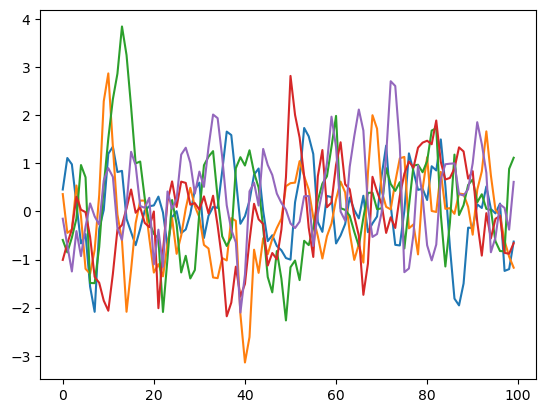

In [75]:
time = torch.linspace(0, 10, 100)
var_gp = VariationalGP(torch.linspace(0, 10, 3))
with torch.no_grad():
    samples = var_gp(time, None, 5)[0]
plt.plot(samples)
var_gp.importance_weights(time[10:], samples[10:], time[:10], samples[:10])
# samples.shape

# ML Models

In [76]:
class ConditionalSpikeRNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=10):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        # initial convolution layer over input
        self.conv = nn.Conv1d(1, hidden_size, kernel_size, padding=kernel_size-1)
        
        # RNN layer (stimulus dimension is 1)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=False)
        self.h_0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        # Linear layer to output spike prob for each neuron
        self.output_layer = nn.Linear(hidden_size, n_neurons)

    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.unsqueeze(-1) # (seq_len, batch_size, 1)

        # shift right
        # x = x.roll(1, 0)  # (seq_len, batch_size, n_neurons)
        # x[0, :, :] = 0.0

        # first convolution layer
        x = self.conv(s.permute((1, 2, 0)))[:, :, :seq_len] # (batch_size, hidden_size, seq_len)

        # Expand h_0 to match batch size
        h_0 = self.h_0.expand(-1, batch_size, -1).contiguous()

        # Forward through RNN
        x, _ = self.rnn(x.permute((2, 0, 1)), h_0)

        output = self.output_layer(x)  # (seq_len, batch_size, n_neurons)

        # returns the intensities
        return output

In [77]:
from torch.distributions.poisson import Poisson

In [78]:
class ConditionalSpikeCNN(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=10):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        layers = []
        for i in range(num_layers):
            in_size = (1 + n_neurons) if i == 0 else hidden_size
            layers.append(nn.Conv1d(in_size, hidden_size, kernel_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())

        self.conv_net = nn.Sequential(
            nn.ZeroPad1d(((kernel_size - 1) * num_layers, 0)), # needed for causality
            *layers,
            # 1x1 convolution layer to output spike intensity for each neuron
            nn.Conv1d(hidden_size, n_neurons, 1)
        )


    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.transpose(0, 1).unsqueeze(1) # (batch_size, 1, seq_len)
        else:
            raise ValueError(f"Wrong shape of s: {s.shape}")

        # # shift right
        x = x.roll(1, 0)  # (seq_len, batch_size, n_neurons)
        x[0, :, :] = 0.0

        output = self.conv_net(torch.cat([s, x.permute((1, 2, 0))], dim=1)) # (batch_size, n_neurons, seq_len)
        # output = self.conv_net(s) # (batch_size, n_neurons, seq_len)
        
        # returns the log-intensities (seq_len, batch_size, n_neurons)
        return output.permute((2, 0, 1))
    
    @torch.no_grad()
    def sample(self, s: torch.Tensor):
        seq_len, batch_size = s.size()

        x = torch.zeros((seq_len, batch_size, self.n_neurons))
        for t in range(seq_len):
            log_intensities = self.forward(s[:t+1], x[:t+1]).clamp(-10, 10)
            x[t] = torch.poisson(log_intensities[-1].exp())

        return x


We train using the poisson negative log likelihood loss function. The Poisson likelihood of a process with intensity $\lambda$ is given by
$$
\mathrm{P}(N(t) = n) = \frac{(\lambda t)^n}{n!} e^{-\lambda t} \,.
$$
If we time-discretize our spikes with time-interval $\Delta t$ and the poisson intensity at time $t_i = i \Delta t$ is given by $\lambda_i$, then the probability of observing $n_i$ spikes in the time-interval $[t_i, t_{i+1})$ is given by
$$
\mathrm{P}(N_i = n_i) = \frac{(\lambda_i \Delta t)^{n_i}}{n_i !} e^{-\lambda_i \Delta t} \,.
$$
Therefore, the negative log likelihood is given by
$$
\mathcal{L} = - \sum_i \ln\mathrm{P}(N_i = n_i) = \sum_i - n_i \ln \lambda_i \Delta t + \lambda_i \Delta t + \ln(n_i !)
$$

In [79]:
class SpikeModel(L.LightningModule):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1, kernel_size=None, model_type='RNN'):
        super().__init__()
        self.save_hyperparameters()
        if model_type == 'RNN':
            if kernel_size is not None:
                raise ValueError('cannot set kernel size for RNN.')
            self.net = ConditionalSpikeRNN(n_neurons, hidden_size, num_layers)
        elif model_type == 'CNN':
            self.net = ConditionalSpikeCNN(n_neurons, hidden_size, num_layers, kernel_size=kernel_size)
        else:
            raise ValueError(f"unsupported model type {model_type}")
        self.loss_fn = nn.PoissonNLLLoss(log_input=True)

    def training_step(self, batch, batch_idx):
        _, s, x = batch
        
        log_intensity = self.net(s, x)
        train_loss = self.loss_fn(log_intensity, x)
        self.log("train_loss", train_loss, prog_bar=True, batch_size=x.size(1))
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        _, s, x = batch
        log_intensity = self.net(s, x)

        val_loss = self.loss_fn(log_intensity, x)
        
        # Log validation loss
        self.log("val_loss", val_loss, prog_bar=True, batch_size=x.size(1))
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-4)
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

# Training

In [80]:
1 / SECONDS_PER_UNIT

10000.0

In [81]:
fraction = 0.7
intervals = np.column_stack((data['rep_begin_time'], data['rep_end_time']))
c = (intervals[:, 0] + fraction * (intervals[:, 1] - intervals[:, 0])).astype(int)
train_intervals = np.column_stack((intervals[:, 0], c))
validation_intervals = np.column_stack((c + 1, intervals[:, 1]))

In [82]:
neurons = data['PickedCells'][:10]
batches = np.arange(data['peak_times'][0], data['rep_begin_time'][0], 50_000)
# train_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, np.column_stack((batches[:-1], batches[1:])))
train_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, train_intervals)
validation_dataset = NeuronDataSet('../data/barmovie0113extended.data', neurons, validation_intervals)
train_dataset[0][2].shape, validation_dataset[0][2].shape

(torch.Size([2106, 10]), torch.Size([903, 10]))

In [83]:
t_train, s_train, x_train = collate_time_series([v for v in train_dataset])
t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
pos_weights = torch.clamp(x_train.shape[0] * x_train.shape[1] / x_train.sum(dim=[0, 1]), 0, 10e3)
pos_weights
x_train.shape, x_val.shape

(torch.Size([2106, 136, 10]), torch.Size([903, 136, 10]))

In [84]:
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor

train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_time_series)
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), collate_fn=collate_time_series)

spike_model = SpikeModel(len(neurons), 16, 2, model_type='CNN', kernel_size=20)
# spike_model = SpikeModel(len(neurons), 64, 2, model_type='RNN')

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",    # Directory to save checkpoints
    filename="{epoch:02d}",  # File name format
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=5,  # Save every N epochs
)

lr_monitor = LearningRateMonitor(logging_interval='step')

# trainer = L.Trainer(max_epochs=150, callbacks=[checkpoint_callback])
trainer = L.Trainer(max_epochs=50, callbacks=[lr_monitor], log_every_n_steps=1)
trainer.fit(model=spike_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type                | Params | Mode 
--------------------------------------------------------
0 | net     | ConditionalSpikeCNN | 8.9 K  | train
1 | loss_fn | PoissonNLLLoss      | 0      | train
--------------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [85]:
def plot_network_performance(model, train_dataset, validation_dataset, out_path=None):
    t_train, s_train, x_train = collate_time_series([v for v in train_dataset])
    t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
    model.net.eval()

    fig, axs = plt.subplots(1 + model.net.n_neurons, 2, width_ratios=[0.7, 0.3], constrained_layout=True)

    for ax, t, s, title in zip(axs[0, :], [t_train, t_val], [s_train, s_val], ["training", "validation"]):
        ax.plot(t[:, 0], s[:, 0])
        ax.set_title(title)


    for j, t, s, x in zip([0, 1], [t_train, t_val], [s_train, s_val], [x_train, x_val]):
        with torch.no_grad():
            log_intensity = model.net(s, x)

        intensity = log_intensity.exp().mean(1)
        for i in range(model.net.n_neurons):
            ax = axs[i+1, j]
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_ylim(-0.2, 0.2)
            ax.plot(t[:, 0], intensity[:, i], linewidth=1)
            ax.plot(t[:, 0], -x[:, :, i].mean(1, dtype=torch.float32), linewidth=1)

    if out_path is not None:
        fig.savefig(out_path)
    return fig

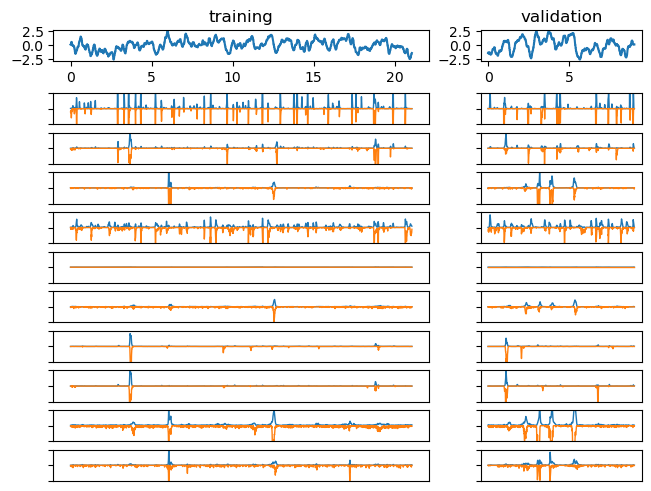

In [86]:
plot_network_performance(spike_model, train_dataset, validation_dataset);

In [131]:
CKPT_PATH = "checkpoints"

for ckpt in os.listdir(CKPT_PATH):
    model = SpikeModel.load_from_checkpoint(os.path.join(CKPT_PATH, ckpt), n_neurons=len(neurons), hidden_size=64, num_layers=2, pos_weights=pos_weights)
    filename, _ = os.path.splitext(ckpt)
    plot_network_performance(model, train_dataset, validation_dataset, out_path=f"../reports/{filename}.png")

RuntimeError: Error(s) in loading state_dict for SpikeModel:
	Missing key(s) in state_dict: "net.conv.weight", "net.conv.bias". 
	Unexpected key(s) in state_dict: "loss_fn.pos_weight". 
	size mismatch for net.rnn.weight_ih_l0: copying a param with shape torch.Size([192, 4]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for net.output_layer.weight: copying a param with shape torch.Size([3, 64]) from checkpoint, the shape in current model is torch.Size([10, 64]).
	size mismatch for net.output_layer.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([10]).

# PWS Estimate

In [87]:
t_val, s_val, x_val = collate_time_series([v for v in validation_dataset])
x_val.shape

torch.Size([903, 136, 10])

In [ ]:
def log_probability(model, s, x):
    model.eval()
    log_intensity = model(s, x)
    return -F.poisson_nll_loss(log_intensity, x, log_input=True, full=True, reduction='none').sum(-1)

In [89]:
stoch_osc = StochasticHarmonicOscillator()
y0 = torch.zeros(1, 2)
y = torchsde.sdeint(stoch_osc, y0, t_val[:,0], dt=1/60)
s_samples = y[:, :, 0]
s_samples.shape

torch.Size([903, 1])

In [90]:
x_samples = spike_model.net.sample(s_samples[:, [0]].repeat(1, 100))
x_samples.shape

torch.Size([903, 100, 10])

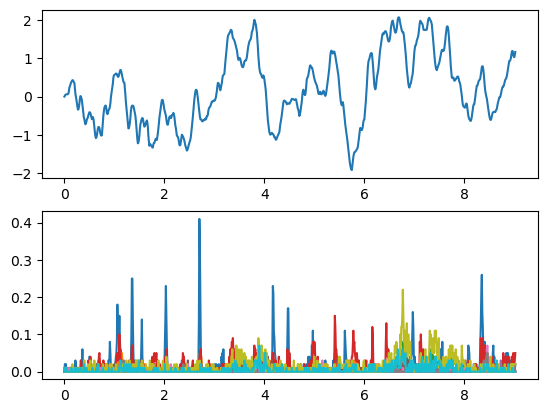

In [91]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_val[:,0], s_samples[:, 0])
ax2.plot(t_val[:,0], x_samples.mean(1))

In [93]:
stoch_osc = StochasticHarmonicOscillator()
y0 = torch.zeros(100, 2)
y = torchsde.sdeint(stoch_osc, y0, t_val[:,0], dt=1/60)
s_samples = y[:, :, 0]
x_samples = spike_model.net.sample(s_samples)

In [94]:

def _pws_samples(s_samples, x_samples, M = 1024):
    seq_len, batch_size = s_samples.shape
    log_conditional = log_probability(spike_model.net, s_samples, x_samples).cumsum(0)
    for i in range(batch_size):
        y0 = torch.zeros(M, 2)
        t = t_val[:seq_len, 0]
        y = torchsde.sdeint(stoch_osc, y0, t, dt=1/60)
        s = y[:, :, 0]
        logp = log_probability(spike_model.net, s, x_samples[:, [i], :].repeat(1, M, 1)).cumsum(0)
        log_marginal = logp.logsumexp(1) - np.log(M)
        yield torch.stack((log_conditional[:, i], log_marginal))

def pws_sample(s_samples, x_samples, M = 1024):
    return torch.stack(list(_pws_samples(s_samples, x_samples, M)))

with torch.no_grad():
    samples = pws_sample(s_samples, x_samples, 512)
samples

tensor([[[-1.3929e-02, -2.7948e-02, -4.2041e-02,  ..., -1.9989e+02,
          -1.9991e+02, -1.9993e+02],
         [-1.3929e-02, -2.7844e-02, -4.1699e-02,  ..., -2.2571e+02,
          -2.2574e+02, -2.2576e+02]],

        [[-1.3929e-02, -2.7931e-02, -4.2010e-02,  ..., -1.8516e+02,
          -1.8518e+02, -1.8519e+02],
         [-1.3929e-02, -2.7843e-02, -4.1695e-02,  ..., -2.2012e+02,
          -2.2021e+02, -2.2028e+02]],

        [[-1.3929e-02, -2.7816e-02, -4.1607e-02,  ..., -2.1621e+02,
          -2.1624e+02, -2.1627e+02],
         [-1.3929e-02, -2.7848e-02, -4.1712e-02,  ..., -2.6272e+02,
          -2.6274e+02, -2.6275e+02]],

        ...,

        [[-1.3929e-02, -2.7847e-02, -4.1794e-02,  ..., -1.6138e+02,
          -1.6141e+02, -1.6144e+02],
         [-1.3929e-02, -2.7846e-02, -4.1706e-02,  ..., -1.9510e+02,
          -1.9513e+02, -1.9516e+02]],

        [[-1.3929e-02, -2.7778e-02, -4.1479e-02,  ..., -2.3205e+02,
          -2.3211e+02, -2.3215e+02],
         [-1.3929e-02, -2.7841e-0

Text(0, 0.5, 'MI [bits]')

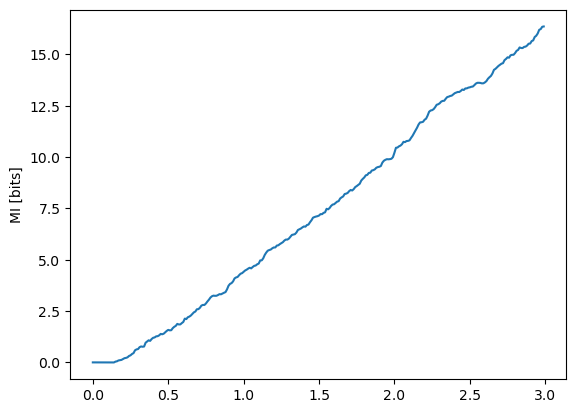

In [101]:
mi = samples[:,0] - samples[:,1]
plt.plot(t_val[:300, 0], mi[:, :300].mean(0) / np.log(2))
plt.ylabel('MI [bits]')

In [49]:
log_probability(spike_model.net, s_val, x_val)

tensor([[ -0.0394,  -0.0394,  -0.0394,  ..., -11.5812,  -0.0394,  -0.0394],
        [ -0.0463,  -4.8581,  -0.0463,  ..., -23.2090,  -0.0463,  -0.0463],
        [ -0.0722,  -0.0722,  -0.0722,  ...,  -3.9979,  -0.0722,  -0.0722],
        ...,
        [ -0.1571,  -0.1571,  -0.1571,  ...,  -3.1531,  -0.1571,  -0.1601],
        [ -0.2236,  -0.2236,  -0.2236,  ...,  -0.2377,  -0.2236,  -0.2377],
        [ -0.1603,  -0.1603,  -0.1603,  ...,  -0.1770,  -0.1603,  -0.1770]],
       grad_fn=<NegBackward0>)

In [ ]:
def _pws_samples(sample_times, duration = 100, N = 1024):
    y0 = torch.zeros((N, 2))
    t_new = torch.arange(duration) * 20e-3
    y = torchsde.sdeint(stoch_osc, y0, t_new, dt=1/60)
    s = y[:, :, 0]
    x = spike_model.net.sampler(s).sample()
    print(x.shape)
    # x = x_val[:t+duration, [i]].expand(-1, N, -1)
    # logp = log_probability(spike_model.net, s, x)[t:].sum(0)
    # log_conditional = log_probability(spike_model.net, s_val[:t+duration, [i]], x_val[:t+duration, [i]])[t:].sum((0,1))
    # yield torch.stack((log_conditional, logp.logsumexp(0) - np.log(N)))

In [ ]:
_pws_samples(range(100))

torch.Size([100, 1024, 10])


In [455]:
i = 1
x_expanded = x_val[:, [i]].expand(-1, s_samples.size(1), -1)

with torch.no_grad():
    logp_conditional = log_probability(spike_model.net, s_val[:, [i]], x_val[:, [i]])
    logp_marginal = log_probability(spike_model.net, s_samples, x_expanded)

dkl = logp_conditional - logp_marginal
dkl.shape

torch.Size([452, 10000])

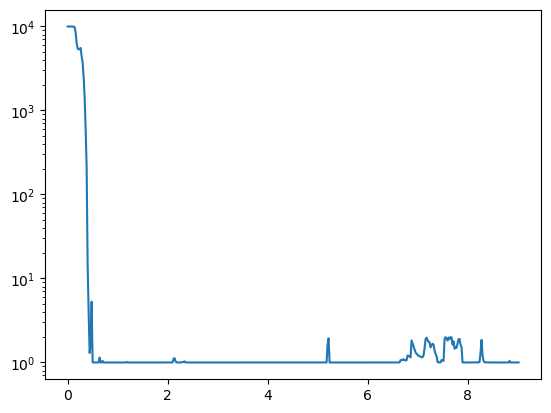

In [456]:
plt.plot(t_val[:, 0], 1 / (nn.functional.softmax(dkl.cumsum(0), 1) ** 2).sum(1))

plt.yscale('log')

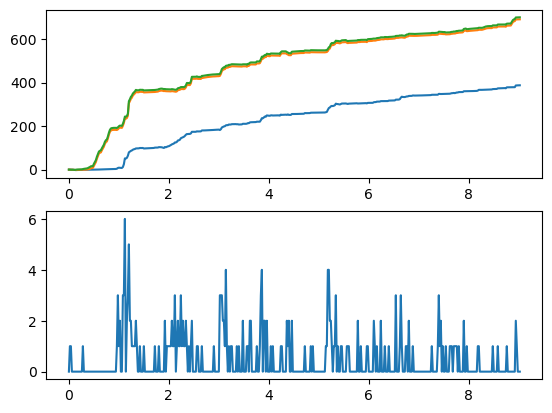

In [457]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_val[:, 0], dkl.cumsum(0).mean(1))
ax1.plot(t_val[:, 0], dkl.cumsum(0).logsumexp(1) - np.log(dkl.size(1)))
ax1.plot(t_val[:, 0], dkl.cumsum(0).max(1)[0])

ax2.plot(t_val[:, 0], x_val[:, [i]].sum(-1))

In [96]:

def smoothed_mi(dkl_T: torch.tensor, kernel_size: int, n_bootstrap: int = 500):
    kernel = torch.ones(1, 1, kernel_size)

    # (batch_size, length - kernel_size)
    smoothed = nn.functional.conv1d(dkl_T, kernel).squeeze(1)

    ess = (1 / (nn.functional.softmax(smoothed, 0) ** 2).sum(0)).mean()

    n = smoothed.size(0)
    indices = torch.randint(0, n, (n_bootstrap,n))

    x = smoothed[indices.flatten(), :].unflatten(0, (n_bootstrap, n))

    return torch.mean(x.logsumexp(1) - np.log(n), dim=-1), ess



def bootstrap_mi_estimate(dkl, length, n_bootstrap = 512):
    mi = torch.empty((len(length), n_bootstrap))
    ess = torch.empty(len(length))

    # (batch_size, 1, length)
    dkl_T = dkl.T.contiguous().unsqueeze(1)

    for i, kernel_size in enumerate(length):
        mi_i, ess_i = smoothed_mi(dkl_T, kernel_size, n_bootstrap)
        mi[i] = mi_i
        ess[i] = ess_i
    return mi, ess
        

length = range(1, 400, 25)
mi, ess = bootstrap_mi_estimate(dkl, length)

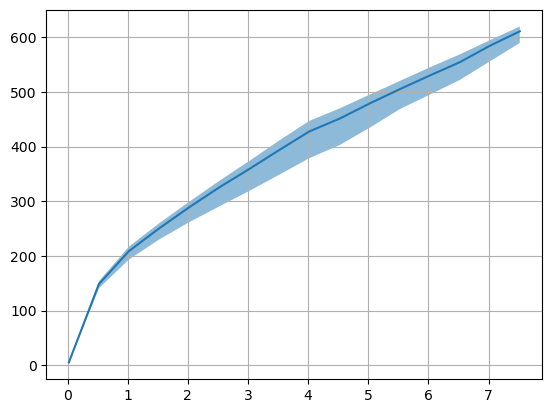

In [460]:
upper = torch.quantile(mi, 0.95, dim=1)
lower = torch.quantile(mi, 0.05, dim=1)
plt.fill_between(t_val[length, 0], lower, upper, alpha=0.5)
plt.plot(t_val[length, 0], torch.mean(mi, dim=1))
plt.grid()

(0.0, 10000.0)

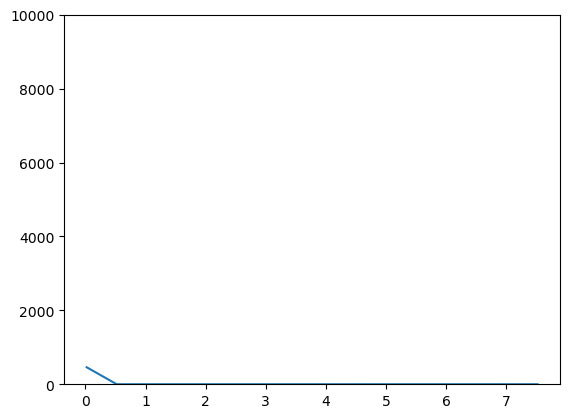

In [263]:
plt.plot(t_val[length, 0], ess)
plt.ylim(0, 1e4)

# Variational PWS

### Encoder

Now create a variational SDE model

In [69]:
class SimpleEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 64, bins=torch.linspace(0.0, 10.0, 126)):
        super().__init__()
        input_dim = bins.size(0) + 2
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        self.output_layer = nn.Linear(input_dim, 1)
        self.bins = bins

    def forward(self, t, y, _context):
        dt = self.bins - t
        t_emb = torch.exp(-0.5 * dt**2 / 0.1**2).expand(y.size(0), -1) # (N, d_emb)
        x = torch.cat([y, t_emb], dim=-1) # (N, d)

        x = self.net(x) + x
        return self.output_layer(x).squeeze(-1)

In [70]:
class VariationalEncoder(nn.Module):
    def __init__(self, query_dim: int, feature_dim: int, hidden_dim: int = 512, n_heads=8):
        super().__init__()

        self.nheads = n_heads
        self.E_head = hidden_dim // n_heads

        self.q_proj = nn.Linear(query_dim, hidden_dim)
        self.k_proj = nn.Linear(feature_dim, hidden_dim)
        self.v_proj = nn.Linear(feature_dim, hidden_dim)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t, y, context):
        t_emb = positional_embedding(t).expand(y.size(0), -1)
        query = torch.cat([y, t_emb], dim=-1).unsqueeze(1) # (N, L=1, signal_dim)
        context = context.unsqueeze(0) # (N, num_spikes, feature_dim)
        
        # (N, L_t, hidden_dim) -> (N, L_t, nheads, E_head) -> (N, nheads, L_t, E_head)
        query = self.q_proj(query).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        key = self.k_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)
        value = self.v_proj(context).unflatten(-1, [self.nheads, self.E_head]).transpose(1, 2)

        # (N, nheads, L=1, E_head)
        x = nn.functional.scaled_dot_product_attention(query, key, value)
        x = x + query # residual connection

        # (N, L=1, hidden_dim)
        x = x.transpose(1, 2).flatten(-2)

        return self.feedforward(x).squeeze((-2, -1))

In [71]:
batch_size = 25
num_spikes = 7
feature_dim = 13
# var_enc = VariationalEncoder(8 + 2, feature_dim)
var_enc = SimpleEncoder()
var_enc(torch.tensor(0.5), torch.rand(batch_size, 2), torch.rand(7, feature_dim))

tensor([-0.1777, -0.1757, -0.1525, -0.1596, -0.1529, -0.1542, -0.1617, -0.1737,
        -0.1559, -0.1760, -0.1628, -0.1695, -0.1776, -0.1724, -0.1790, -0.1563,
        -0.1643, -0.1662, -0.1493, -0.1660, -0.1496, -0.1532, -0.1616, -0.1561,
        -0.1745], grad_fn=<SqueezeBackward1>)

In [72]:
class VariationalSDE(nn.Module):
    def __init__(self, base_model: nn.Module, encoder: nn.Module, context: torch.tensor):
        super().__init__()
        self.context = context
        self.base_model = base_model

        self.noise_type = base_model.noise_type
        self.sde_type = base_model.sde_type

        self.encoder = encoder

    # Drift
    def f(self, t, y):
        drift = self.base_model.f(t, y)
        drift[:, 1] += self.encoder(t, y, self.context)
        return drift

    # Diffusion
    def g(self, t, y):
        return self.base_model.g(t, y)

    # Base measure
    def h(self, t, y):
        return self.base_model.f(t, y)

In [73]:
class VariationalConditionalSDE(nn.Module):
    def __init__(self, n_neurons, sde_dt = 1/60):
        super().__init__()

        self.prior_sde = StochasticHarmonicOscillator()
        # self.encoder = VariationalEncoder(2 + 8, n_neurons + 8, n_neurons * 8)
        self.encoder = SimpleEncoder(128)

        self.sde_dt = sde_dt

    def forward(self, t: torch.tensor, x_emb: torch.tensor, batch_size: int = 1):
        sde = VariationalSDE(self.prior_sde, self.encoder, x_emb)
        y0 = torch.zeros((batch_size, 2))
        y, logqp = torchsde.sdeint(sde, y0, t, method='euler', dt=self.sde_dt, logqp=True)
        return y[...,0], logqp.sum(0).mean()
        

### Lightning Module

In [74]:
class VariationalModel(L.LightningModule):
    def __init__(self, forward_model, backward_model, variational_samples=128):
        super().__init__()
        self.forward_model = forward_model
        self.backward_model = backward_model

        self.forward_model.eval()
        self.forward_model.requires_grad_(False)

        self.variational_samples = variational_samples
        
    def training_step(self, batch, batch_idx):
        t, s, x, x_emb = batch

        assert len(x_emb) == 1

        t = t[:, 0].contiguous()
        x_emb = x_emb[0]
        
        s, kl_div = self.backward_model(t, x_emb, self.variational_samples)

        x_expanded = x.expand(-1, self.variational_samples, -1)
        logp_forward = log_probability(self.forward_model, s, x_expanded).sum((0,-1)).mean()

        self.log("kl_div", kl_div)
        self.log("logp", logp_forward)

        # ELBO
        train_loss = -(logp_forward - kl_div)

        self.log("train_loss", train_loss)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=1e-1)
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-1, total_steps=total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }

In [75]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

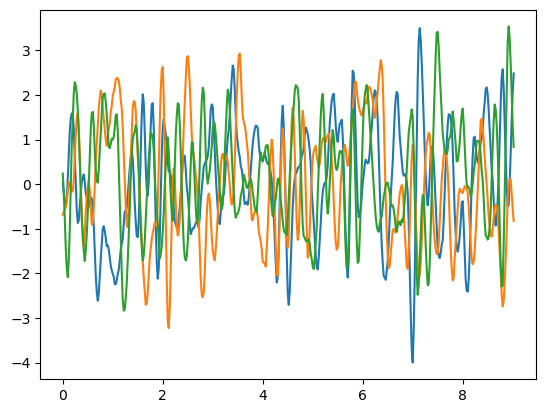

In [76]:
# stoch_osc = StochasticHarmonicOscillator(50e-3, 1e3, 9.42)
# backward_model = VariationalConditionalSDE(len(neurons))

backward_model = VariationalGP(torch.arange(test_t.min(), test_t.max(), 0.1))

s, logqs = backward_model(test_t, test_x_emb, 3)
plt.plot(test_t, s.detach())

In [77]:
forward_model = spike_model.net
variational_model = VariationalModel(forward_model, backward_model)
variational_model

VariationalModel(
  (forward_model): ConditionalSpikeCNN(
    (conv_net): Sequential(
      (0): ZeroPad1d((18, 0))
      (1): Conv1d(1, 16, kernel_size=(10,), stride=(1,))
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(10,), stride=(1,))
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv1d(16, 10, kernel_size=(1,), stride=(1,))
    )
  )
  (backward_model): VariationalGP(
    (kernel): StochasticHarmonicOscillatorKernel()
  )
)

In [78]:
trainer = L.Trainer(max_epochs=15, log_every_n_steps=1)
trainer.fit(model=variational_model, train_dataloaders=DataLoader(validation_dataset, shuffle=True, collate_fn=collate_time_series))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
/data/clusterusers/reinhardt/miniconda3/envs/ml-pws/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | forward_model  | ConditionalSpikeCNN | 3.0 K  | eval 
1 | backward_model | VariationalGP       | 8.4 K  | train
---------------------------------------------------------------
8.4 K     Trainable params
3.0 K     Non-trainable params
11.4 K    Total params
0.045     Total estimated model params size (MB)
2         Modules in train mode
10        Modu

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


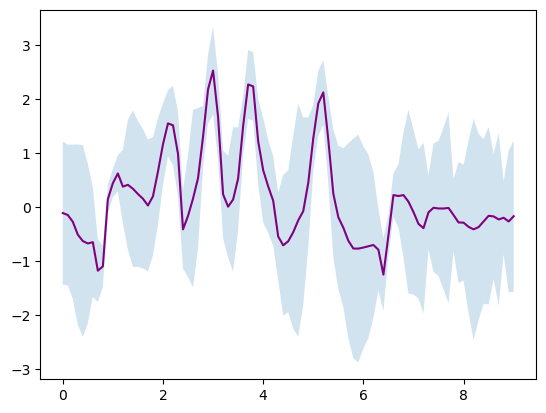

In [79]:
gp_var = variational_model.backward_model
S_L = gp_var.get_sl().detach()
mu = gp_var.m[:, 0].detach()
sigma = torch.diag(S_L @ S_L.T).sqrt()
plt.fill_between(gp_var.t_obs, mu - 2*sigma, mu + 2*sigma, alpha=0.2)
plt.plot(gp_var.t_obs, mu, color='purple')

In [80]:
test_t, test_s, test_x, test_x_emb = validation_dataset[0]

In [81]:
with torch.no_grad():
    posterior_samples, kl_div = variational_model.backward_model(test_t, test_x_emb, 4096)

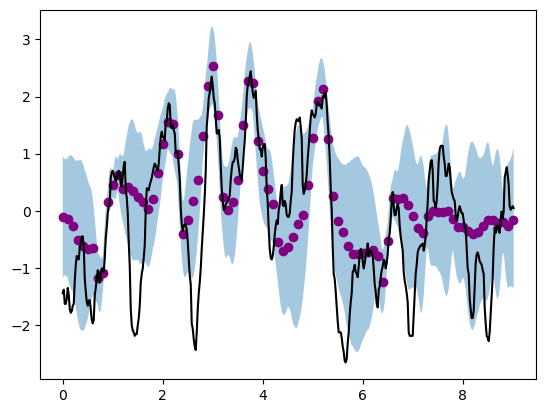

In [87]:
plt.fill_between(test_t, *posterior_samples.quantile(torch.tensor([0.05, 0.95]), dim=1), alpha=0.4)
plt.plot(test_t, test_s, color='black')
gp_var = variational_model.backward_model
plt.scatter(gp_var.t_obs, gp_var.m[:, 0].detach(), color='purple')

In [110]:
durations = np.arange(1, 100, 15)
test_t[durations]

tensor([0.0200, 0.3200, 0.6200, 0.9200, 1.2200, 1.5200, 1.8200])

Compute the marginal probability for duration $\tau$.

$$
\mathrm{P}(x_{t:t+\tau}|x_{<t}, s_{<t}) = \left\langle \mathrm{P}(x_{t:t+\tau}|s_{t:t+\tau},x_{<t},s_{<t}) \frac{\mathrm{P}(s_{t:t+\tau}|s_{<t})}{q(s_{t:t+\tau}|s_{<t})} \right\rangle_{q(s_{t:t+\tau}|s_{<t})}
$$

In [ ]:
mi_estimates = torch.zeros(len(durations))
with torch.no_grad():
    log_conditional = log_probability(spike_model.net, test_s.unsqueeze(1), test_x.unsqueeze(1)).sum(-1).squeeze(1)
    logp_forward = log_probability(spike_model.net, posterior_samples, test_x.unsqueeze(1)).sum(-1)
    for k, duration in enumerate(durations):
        # sum pooling
        w = F.lp_pool1d(logp_forward.T, 1, duration, 1)

        # calculate importance weights log(q/p) and subtract them from the pooled logp
        for i in range(w.size(1)):
            importance_weights = gp_var.importance_weights(test_t[i:i+duration], posterior_samples[i:i+duration])
            w[:, i] -= importance_weights

        # average in log space
        logN = np.log(w.size(0))
        w = w.logsumexp(0) - logN
        mi_estimates[k] = log_conditional.mean() * duration - w.mean()

Text(0.5, 0, 'duration (s)')

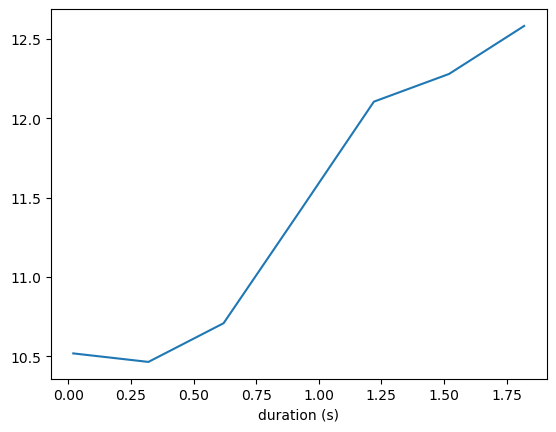

In [134]:
plt.plot(test_t[durations], mi_estimates * np.log(2))
plt.xlabel('duration (s)')

In [84]:
with torch.no_grad():
    logp_forward = log_probability(spike_model.net, posterior_samples, test_x.unsqueeze(1)).sum(-1)
    kl_div = variational_model.backward_model.kl_div(test_t)
logp_forward.shape, kl_div.shape # (length)

(torch.Size([452, 4096]), torch.Size([451]))

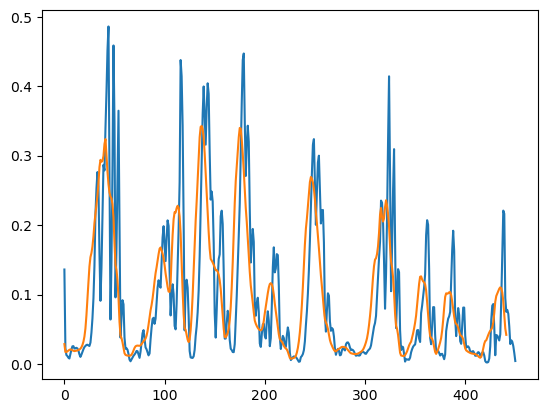

In [ ]:

plt.plot(kl_div)
plt.plot(F.lp_pool1d(kl_div.unsqueeze(0), 1.0, 10, 1).T / 10)

In [ ]:
def 

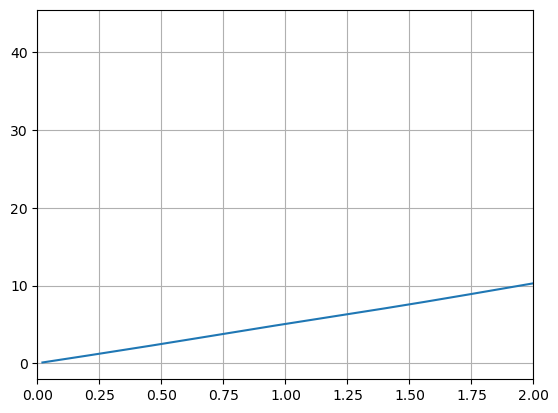

In [130]:
N = kl_div.size(0)
filters = torch.ones((N, N)).tril().unsqueeze(1)
mi = nn.functional.conv1d(kl_div.reshape((1, -1)), filters, padding=filters.size(0))
mask = torch.cat([torch.zeros((N, N)), torch.ones((N, 1)), 1 - filters.squeeze(1).flip(1)], dim=1)
plt.plot(test_t[1:], (mi * mask).sum(1) / mask.sum(1))
plt.xlim(0,2)
plt.grid()

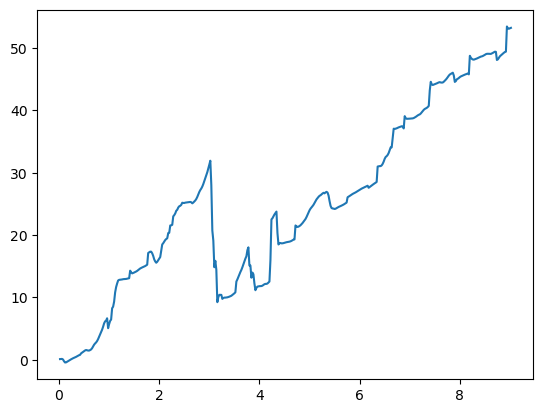

In [159]:
# ELBO
log_marginal_lb = logp_forward[1:].mean(1) - kl_div
log_conditional = log_probability(spike_model.net, test_s.unsqueeze(1), test_x.unsqueeze(1)).sum((-2, -1))
dkl = log_conditional[1:] - log_marginal_lb
plt.plot(test_t[1:], dkl.cumsum(0))

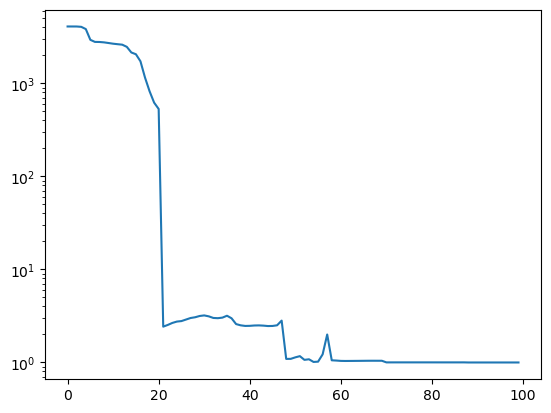

In [132]:
ess = (1 / (nn.functional.softmax(dkl.cumsum(0)[:100], 1) ** 2).sum(1))
plt.plot(ess)
plt.yscale('log')

(0.0, 2.0)

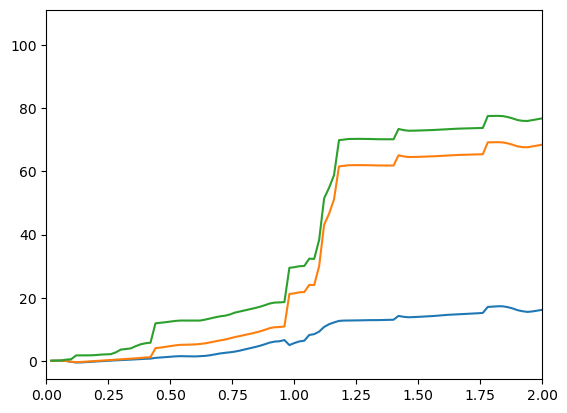

In [133]:
plt.plot(test_t[1:], dkl.cumsum(0).mean(1))
plt.plot(test_t[1:], dkl.cumsum(0).logsumexp(1) - np.log(dkl.size(1)))
plt.plot(test_t[1:], dkl.cumsum(0).max(1)[0])
plt.xlim(0, 2)

In [134]:
length = range(1, 100, 10)
mi, ess = bootstrap_mi_estimate(dkl, length, n_bootstrap=512)

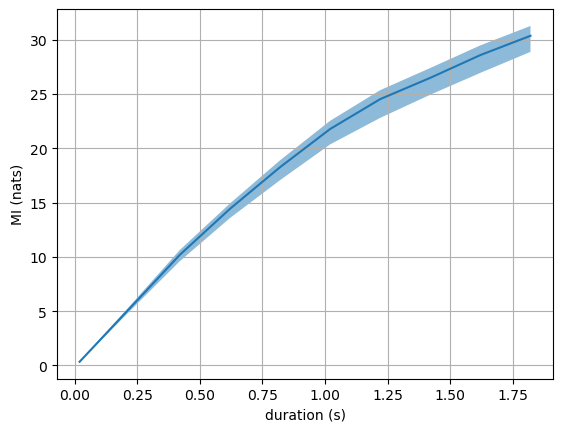

In [135]:
upper = torch.quantile(mi, 0.95, dim=1)
lower = torch.quantile(mi, 0.05, dim=1)
plt.fill_between(t_val[length, 0], lower, upper, alpha=0.5)
plt.plot(t_val[length, 0], torch.mean(mi, dim=1))
plt.xlabel('duration (s)')
plt.ylabel('MI (nats)')
plt.grid()

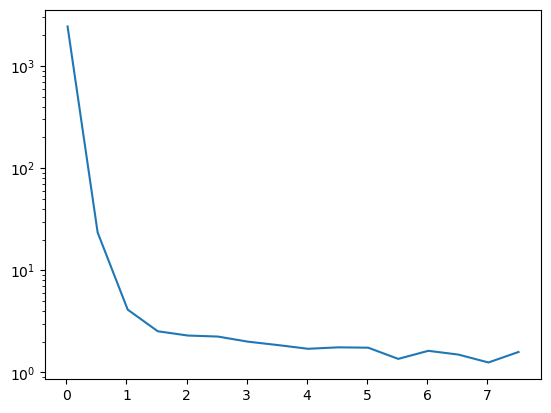

In [354]:
plt.plot(t_val[length, 0], ess)
plt.yscale('log')

# Data Analysis

In [1]:
from pathlib import Path
import json
import numpy as np
from matplotlib import pyplot as plt

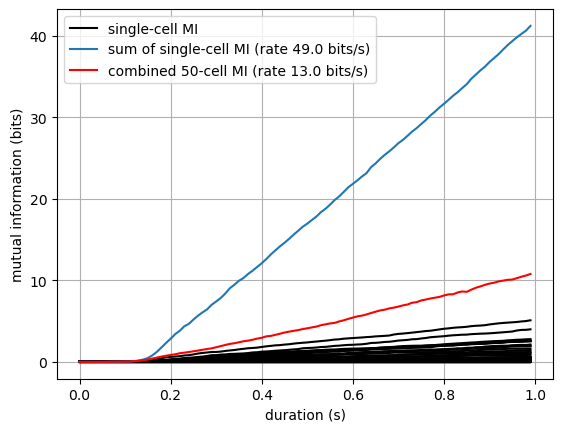

In [21]:
def plot_results(json_folder: Path, pattern: str = "out_*.json"):
    """
    Read JSON files from the specified folder, process them, and plot a line per neuron.

    Args:
        json_folder (Path): Path to the folder containing JSON output files.
        pattern (str): Glob pattern to match result files. Default is "out_*.json".
    """
    json_files = sorted(json_folder.glob(pattern))
    
    if not json_files:
        print("No JSON files found.")
        return

    fig, ax = plt.subplots()

    mi_total = []

    for file in json_files:
        with open(file, "r") as f:
            data = json.load(f)
            result = data['pws_result']
            t = np.array(result['t'])
            mi = np.array(result['mutual_information']) / np.log(2)
            
            if len(mi_total) == 0:
                ax.plot(t, np.mean(mi, axis=0), color='black', label='single-cell MI')
            else:
                ax.plot(t, np.mean(mi, axis=0), color='black')

            mi_total.append(np.mean(mi, axis=0))

    sum_mi = np.sum(np.stack(mi_total), axis=0)
    rate = (sum_mi[-1] - sum_mi[30]) / (t[-1] - t[30])
    ax.plot(t, sum_mi, label=f'sum of single-cell MI (rate {np.round(rate, 1)} bits/s)')

    with open(json_folder / 'full_out.json') as f:
        data = json.load(f)
        result = data['pws_result']
        t = np.array(result['t'])
        mi = np.clip(np.array(result['mutual_information']) / np.log(2), 0.0, 40.0)
        mi_mean = np.nanmean(mi, axis=0)
        rate = (mi_mean[-1] - mi_mean[30]) / (t[-1] - t[30])
        ax.plot(t, mi_mean, color='red', label=f'combined 50-cell MI (rate {np.round(rate, 1)} bits/s)')

    ax.set_xlabel('duration (s)')
    ax.set_ylabel('mutual information (bits)')

    ax.legend()
    ax.grid()

    # ax.set_xlim(0, 0.5)
    # ax.set_ylim(0, 10)

    return fig

plot_results(Path('../experiments/experiment2'));